In [1]:
import os

target_dir = "../"
zip_file_path = "generated.zip"

if not os.path.exists(target_dir + 'generated'):
    print(f"The directory {target_dir} does not exist. Proceeding with download.")

    !apt-get update
    !apt-get install unzip
    
    !curl "https://drive.usercontent.google.com/download?id=1cz8zdYliS4NFryZZfAXyMwWXV6gvwpor&confirm=xxx" -o {zip_file_path}
    !mkdir -p {target_dir}
    
    !unzip {zip_file_path} -d {target_dir}
    
    print(f"File downloaded and extracted to {target_dir}")
    
    !rm {zip_file_path}
else:
    print(f"The directory {target_dir} already exists. No action taken.")

The directory ../ already exists. No action taken.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import sys
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

from pathlib import Path

repo_root = Path.cwd().parent.resolve()
sys.path.append(str(repo_root))

from sklearn.model_selection import train_test_split
from src.data.auction_dataset import AuctionDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
filters = [
    #("g_hours_on_sale_max", "<=", 50),
    #("g_current_hours_max", "<=", 50),
    #("g_hours_on_sale_len", "<=", 64),
    ("record", ">=", "2025-07-01"),
    ("record", "<=", "2025-09-01"),
]

pairs = pd.read_parquet("../generated/indices.parquet", engine="pyarrow", filters=filters)

pairs.head()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max,start,length
0,2025-07-01 00:00:00,17557,11,13.18,12.68,0.00,40.00,13.82,14.91,2.00,48.00,21861,11
1,2025-07-01 01:00:00,17557,10,13.50,12.56,1.00,39.00,11.40,10.77,3.00,35.00,21872,10
2,2025-07-01 02:00:00,17557,10,12.50,12.56,0.00,38.00,12.40,10.77,4.00,36.00,21882,10
3,2025-07-01 03:00:00,17557,9,12.89,12.49,1.00,37.00,14.33,10.96,6.00,37.00,21892,9
4,2025-07-01 04:00:00,17557,9,11.89,12.49,0.00,36.00,15.33,10.96,7.00,38.00,21901,9


## Prepare and balance data

In [4]:
print(f"Pairs: {len(pairs)}")

split_idx = int(len(pairs) * 0.95)

train_pairs = pairs.iloc[:split_idx]
train_pairs = train_pairs.iloc[: int(len(train_pairs) * 0.90)]

print(f"Train pairs: {len(train_pairs)}")

val_pairs = pairs.iloc[split_idx:]

print(f"Val pairs: {len(val_pairs)}")

del pairs

Pairs: 19183468
Train pairs: 16401864
Val pairs: 959174


In [5]:
train_pairs.tail()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max,start,length
16401859,2025-08-12 11:00:00,13944,3,17.33,9.03,7.00,29.00,21.67,6.65,16.00,31.00,7575,3
16401860,2025-08-12 12:00:00,13944,3,16.33,9.03,6.00,28.00,22.67,6.65,17.00,32.00,7578,3
16401861,2025-08-12 13:00:00,13944,3,15.33,9.03,5.00,27.00,23.67,6.65,18.00,33.00,7581,3
16401862,2025-08-12 14:00:00,13944,3,14.33,9.03,4.00,26.00,24.67,6.65,19.00,34.00,7584,3
16401863,2025-08-12 15:00:00,13944,3,13.33,9.03,3.00,25.00,25.67,6.65,20.00,35.00,7587,3


In [6]:
val_pairs.head()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max,start,length
18224294,2025-08-17 20:00:00,12161,2,4.50,0.50,4.00,5.00,30.50,12.50,18.00,43.00,7809,2
18224295,2025-08-17 21:00:00,12161,3,18.00,20.51,3.00,47.00,21.00,18.02,0.00,44.00,7811,3
18224296,2025-08-17 22:00:00,12161,3,17.00,20.51,2.00,46.00,22.00,18.02,1.00,45.00,7814,3
18224297,2025-08-17 23:00:00,12161,3,16.00,20.51,1.00,45.00,23.00,18.02,2.00,46.00,7817,3
18224298,2025-08-17 00:00:00,16539,3,25.67,14.52,13.00,46.00,10.00,13.44,0.00,29.00,13371,3


(array([3.218440e+05, 4.315260e+05, 7.791630e+05, 9.741090e+05,
        1.376297e+06, 1.696502e+06, 1.826197e+06, 1.804811e+06,
        1.762942e+06, 1.467492e+06, 1.149604e+06, 7.912690e+05,
        5.959840e+05, 4.505580e+05, 2.787050e+05, 2.042600e+05,
        1.752560e+05, 1.123930e+05, 8.414000e+04, 9.811200e+04,
        7.744000e+03, 4.398000e+03, 2.070000e+03, 1.590000e+03,
        1.803000e+03, 1.008000e+03, 3.300000e+01, 1.263000e+03,
        5.110000e+02, 2.800000e+02]),
 array([ 0.        ,  2.36666667,  4.73333333,  7.1       ,  9.46666667,
        11.83333333, 14.2       , 16.56666667, 18.93333333, 21.3       ,
        23.66666667, 26.03333333, 28.4       , 30.76666667, 33.13333333,
        35.5       , 37.86666667, 40.23333333, 42.6       , 44.96666667,
        47.33333333, 49.7       , 52.06666667, 54.43333333, 56.8       ,
        59.16666667, 61.53333333, 63.9       , 66.26666667, 68.63333333,
        71.        ]),
 <BarContainer object of 30 artists>)

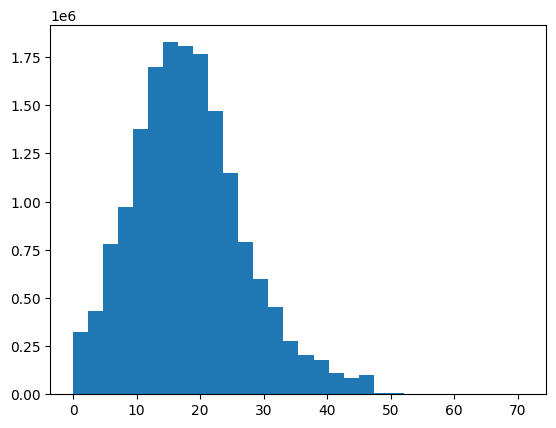

In [7]:
# histogram of group_hours_on_sale_mean
plt.hist(train_pairs['g_hours_on_sale_mean'], bins=30)

In [8]:
val_pairs.sample(5)

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max,start,length
18347676,2025-08-17 22:00:00,12249,1,16.00,0.00,16.00,16.00,31.00,0.00,31.00,31.00,8616,1
18999186,2025-08-19 02:00:00,8053,6,24.17,17.01,0.00,46.00,18.83,13.27,1.00,37.00,18539,6
18709684,2025-08-18 00:00:00,8680,27,28.00,0.00,28.00,28.00,19.00,0.00,19.00,19.00,15167,27
19033116,2025-08-19 14:00:00,724,4,16.25,15.86,3.00,43.00,25.00,15.70,4.00,45.00,11515,4
18917521,2025-08-19 08:00:00,8439,7,17.43,8.23,3.00,33.00,19.29,15.30,3.00,44.00,17624,7


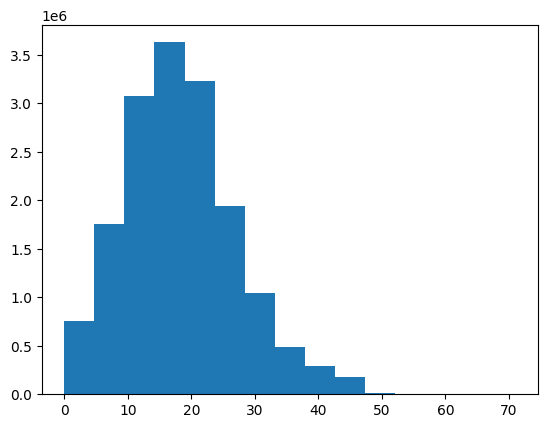

In [9]:
plt.hist(train_pairs['g_hours_on_sale_mean'], bins=15)
plt.show()

In [10]:
import json
import os

mappings_dir = '../generated/mappings'

with open(os.path.join(mappings_dir, 'item_to_idx.json'), 'r') as f:
    item_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'context_to_idx.json'), 'r') as f:
    context_to_idx = json.load(f)
    
with open(os.path.join(mappings_dir, 'bonus_to_idx.json'), 'r') as f:
    bonus_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'modtype_to_idx.json'), 'r') as f:
    modtype_to_idx = json.load(f)

In [11]:
feature_stats = torch.load('../generated/feature_stats.pt')

In [12]:
from src.data.auction_dataset import AuctionDataset
from src.data.utils import collate_auctions

batch_size = 16
max_hours_back = 24

train_pairs = train_pairs[['record', 'item_index', 'start', 'length']]
val_pairs = val_pairs[['record', 'item_index', 'start', 'length']]

train_idx_map = {
    (int(row.item_index), row.record): (int(row.start), int(row.length))
    for row in train_pairs.itertuples(index=False)
}

val_idx_map = {
    (int(row.item_index), row.record): (int(row.start), int(row.length))
    for row in val_pairs.itertuples(index=False)
}

train_dataset = AuctionDataset(train_pairs, train_idx_map, feature_stats=feature_stats, max_hours_back=max_hours_back, path='../generated/sequences.h5')
val_dataset = AuctionDataset(val_pairs, val_idx_map, feature_stats=feature_stats, max_hours_back=max_hours_back, path='../generated/sequences.h5')

del train_pairs, val_pairs
del train_idx_map, val_idx_map

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=4, prefetch_factor=4, pin_memory=False, persistent_workers=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=4, prefetch_factor=4, pin_memory=False, persistent_workers=True)

#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=0)
#val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=0)

## Model definition

In [13]:
test_data_loader = True

if test_data_loader:
    iter_loader = iter(train_dataloader)
    batch = next(iter_loader)
    auctions = batch['auction_features']
    item_index = batch['item_index']
    contexts = batch['contexts']
    bonus_ids = batch['bonus_ids']
    modifier_types = batch['modifier_types']
    modifier_values = batch['modifier_values']
    listing_age = batch['listing_age']
    time_left = batch['time_left']
    hour_of_week = batch['hour_of_week']
    y = batch['target']

    print(f'auctions: {auctions.shape}')
    print(f'item_index: {item_index.shape}')
    print(f'contexts: {contexts.shape}')
    print(f'bonus_ids: {bonus_ids.shape}')
    print(f'modifier_types: {modifier_types.shape}')
    print(f'modifier_values: {modifier_values.shape}')
    print(f'hour_of_week: {hour_of_week.shape}')
    print(f'y: {y.shape}')
    
    print("\nAuction feature statistics:")
    for i in range(auctions.shape[-1]):
        mean = auctions[..., i].mean().item()
        std = auctions[..., i].std().item()
        print(f"Feature {i}: mean = {mean:.3f}, std = {std:.3f}")

auctions: torch.Size([16, 340, 5])
item_index: torch.Size([16, 340])
contexts: torch.Size([16, 340])
bonus_lists: torch.Size([16, 340, 9])
modifier_types: torch.Size([16, 340, 11])
modifier_values: torch.Size([16, 340, 11])
hour_of_week: torch.Size([16, 340])
y: torch.Size([16, 340])

Auction feature statistics:
Feature 0: mean = -1.100, std = 1.582
Feature 1: mean = -0.140, std = 0.573
Feature 2: mean = 0.000, std = 0.000
Feature 3: mean = 0.034, std = 0.588
Feature 4: mean = -0.005, std = 0.577


In [14]:
from src.models.auction_transformer import AuctionTransformer

input_size = 5
embedding_dim = 32
d_model = 256
dim_feedforward = d_model * 4
nhead = 16
num_layers = 4
dropout_p = 0.0
n_items = len(item_to_idx)
n_contexts = len(context_to_idx) + 1
n_bonuses = len(bonus_to_idx)
n_modtypes = len(modtype_to_idx)

model = AuctionTransformer(
    input_size, 
    n_items, 
    n_contexts,
    n_bonuses,
    n_modtypes,
    embedding_dim, 
    d_model, 
    dim_feedforward, 
    nhead, 
    num_layers,
    dropout_p=dropout_p,
    learning_rate=1e-4,
    logging_interval=1000,
    quantiles=[0.1, 0.5, 0.9],
    max_hours_back=max_hours_back,
    log_raw_batch_data=False,
    log_step_predictions=False,
)

print(sum(p.numel() for p in model.parameters()))

4083267


## Training

In [ ]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.profilers import PyTorchProfiler
from torch.profiler import schedule, tensorboard_trace_handler


!rm -rf ../generated/logs

name = f'transformer-4M-quantile-how-historical_{max_hours_back}'

logger = WandbLogger(
    project="auction_transformer",
    name=name
)

checkpoint_callback = ModelCheckpoint(
    dirpath=f'../models/{name}',
    filename='epoch_{epoch:02d}',
    save_top_k=-1,
    every_n_train_steps=10000,
    save_last=True
)
"""
profiler = PyTorchProfiler(
    dirpath="profiler_logs",              # where traces go
    filename="profile",                   # base name per rank
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
    on_trace_ready=tensorboard_trace_handler("profiler_logs"),
    schedule=schedule(wait=1, warmup=1, active=3, repeat=2),
)"""

trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=10,
    logger=logger,
    limit_val_batches=500,
    val_check_interval=0.1,
    precision="bf16",
    callbacks=[checkpoint_callback],
    gradient_clip_val=3.0,
    #profiler=profiler,
)

trainer.fit(model, train_dataloader, val_dataloader)

/home/angel/miniconda3/lib/python3.13/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
